# The purpose of this notebook is to calculate the Weight of Evidence (WOE) and Information Value (IV) for each predictor variable in our cleaned dataset.

### WOE and IV help us identify which variables have the strongest predictive power in distinguishing good (non-default) vs bad (default) borrowers for our Elder-Care Support Loan credit scorecard.

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)

DATA_PATH = Path("merged_applicant_and_bureau_cleaned.csv")   
OUT_DIR = Path("woe_iv_outputs")                              # local subfolder for outputs
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
TARGET_COL = "TARGET"   # 0 = good, 1 = bad 

In [3]:
# Load your cleaned dataset
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])  # show first 20 columns
df[TARGET_COL].value_counts(dropna=False)
df.head()


Shape: (254358, 28)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Function takes in a data frame for a variable with columns: variable values, 'TARGET' values, bin range corresponding to varaible value.

In [4]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data

# # test the function
# df_bin_data = df.loc[:,('AMT_CREDIT', 'TARGET')].copy()
# df_bin_data['Bin_Range'] = pd.qcut(df['AMT_CREDIT'], q=20)
# woe_iv(df_bin_data)

# Function to calculate WOE, IV and plot IV

In [5]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    

IV for AMT_CREDIT with 5 bins: 0.0402


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\1750641458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

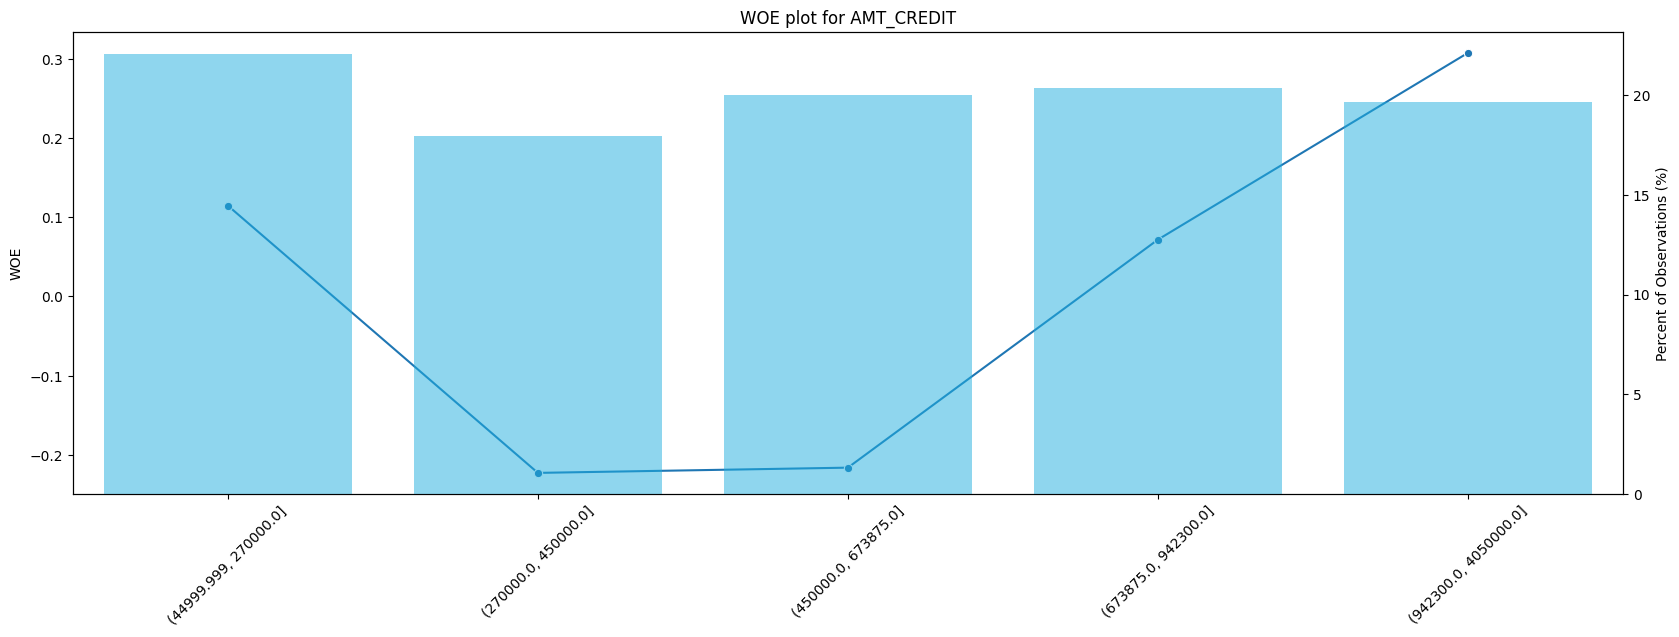

In [6]:
# test the function - create a copy first
variable = 'AMT_CREDIT'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# Coarse classing Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT with 4 categories: 0.0235


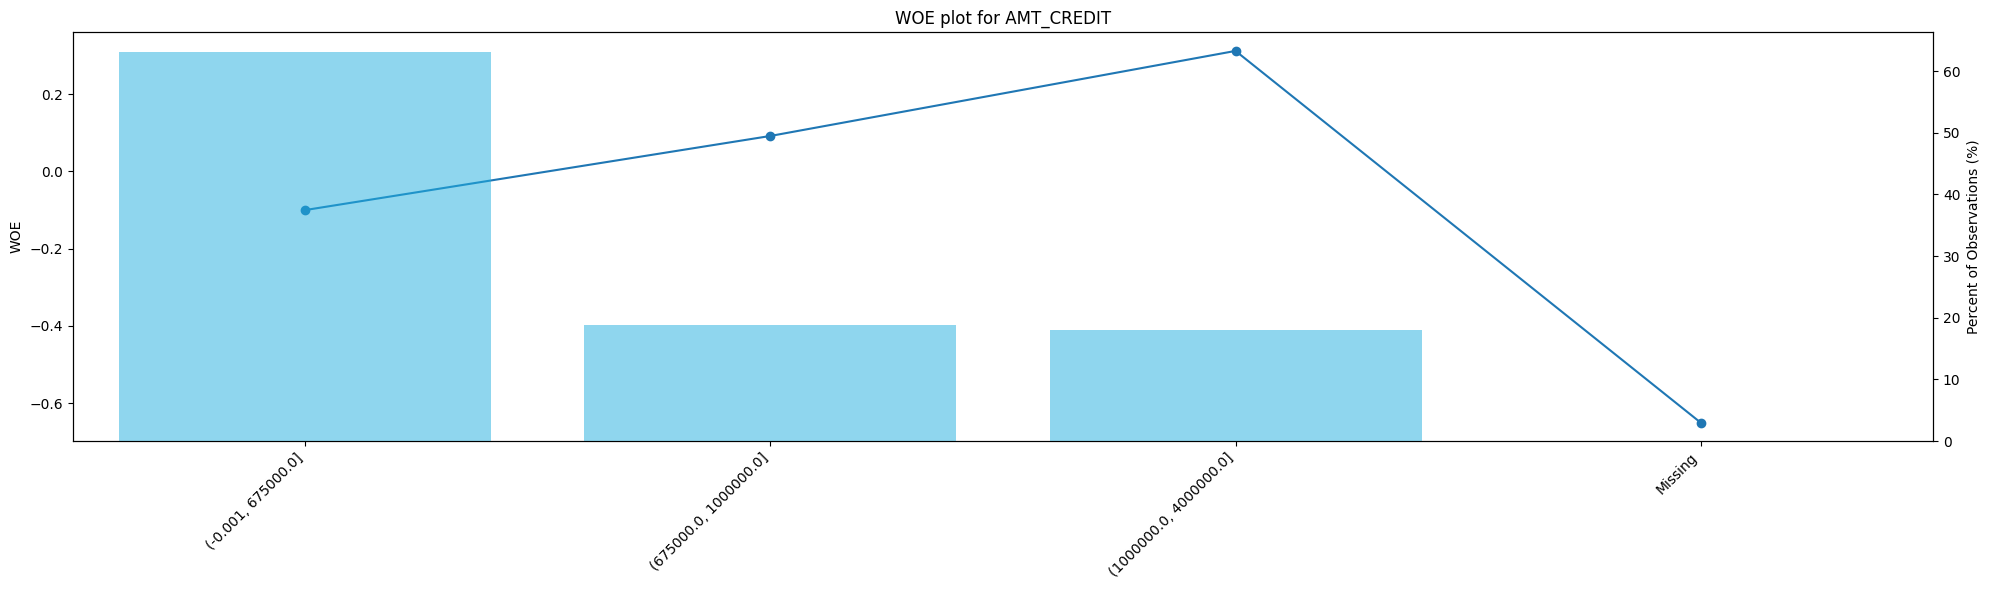

In [29]:
# sample code

bin_edges = [0,675000, 1000000, 4000000]
variable = 'AMT_CREDIT'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DAYS_EMPLOYED

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3718830670.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for DAYS_EMPLOYED with 6 bins: 0.0942


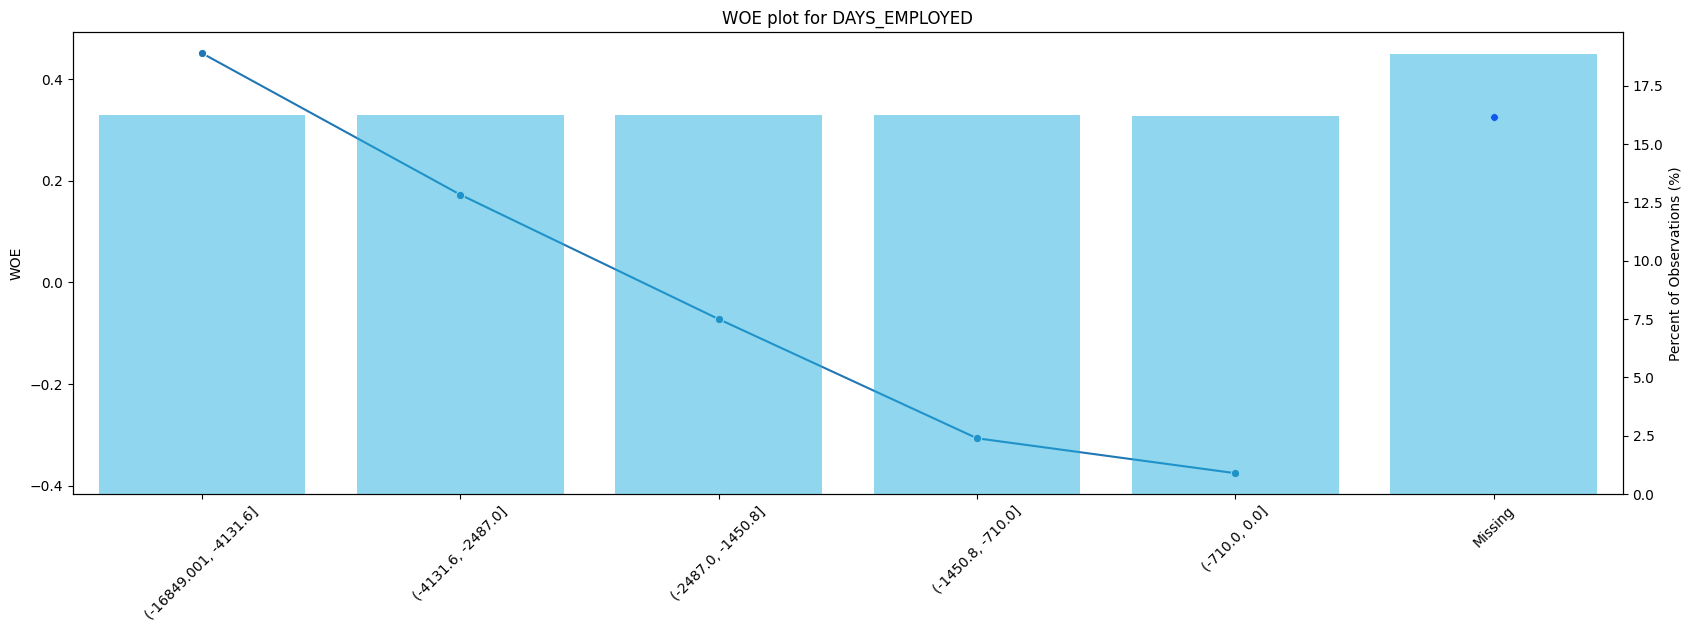

In [8]:
# test the function - create a copy first
variable = 'DAYS_EMPLOYED'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DAYS_EMPLOYED with 4 bins: 0.0894


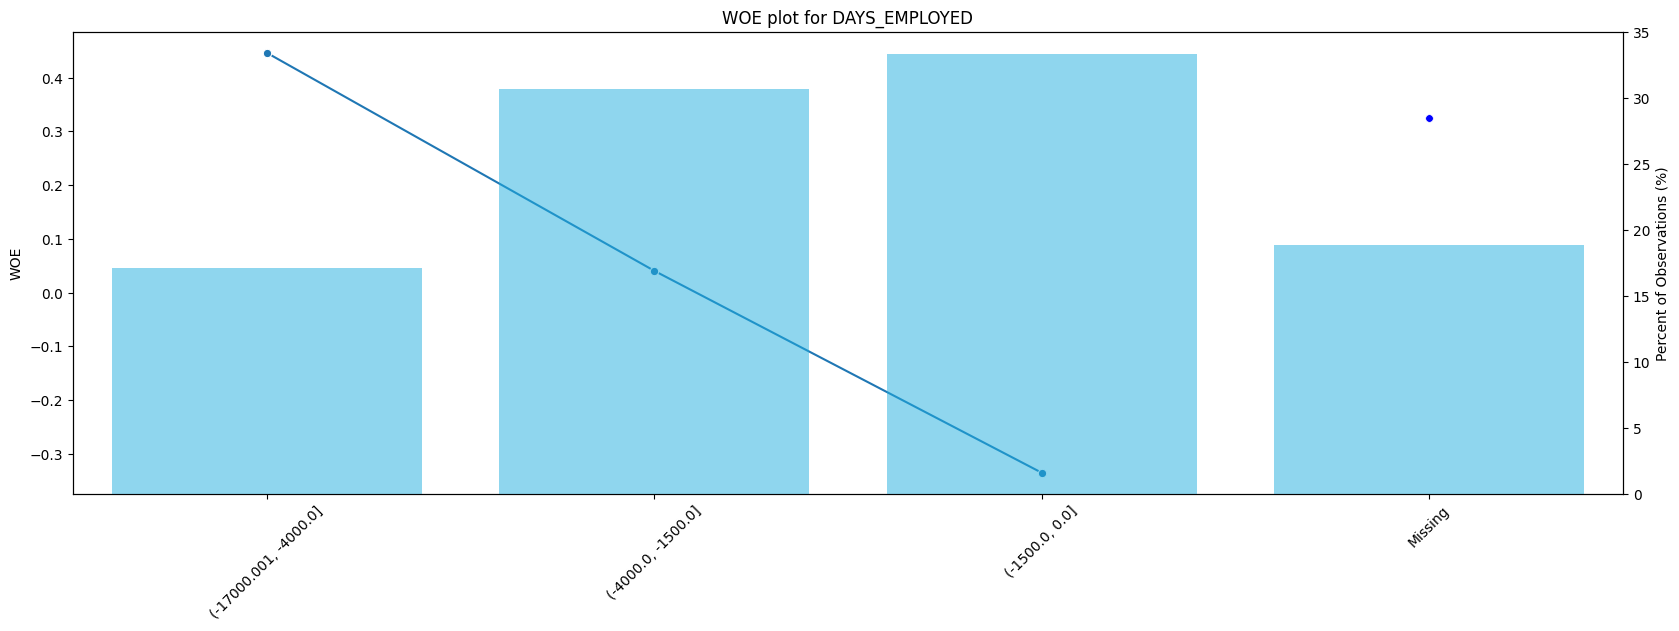

In [9]:
# sample code

bin_edges = [-17000, -4000, -1500, 0]
variable = 'DAYS_EMPLOYED'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DEBT_RATIO

### AMT_CREDIT_SUM_DEBT_sum

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3052190614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AMT_CREDIT_SUM_DEBT_sum with 6 bins: 0.0479


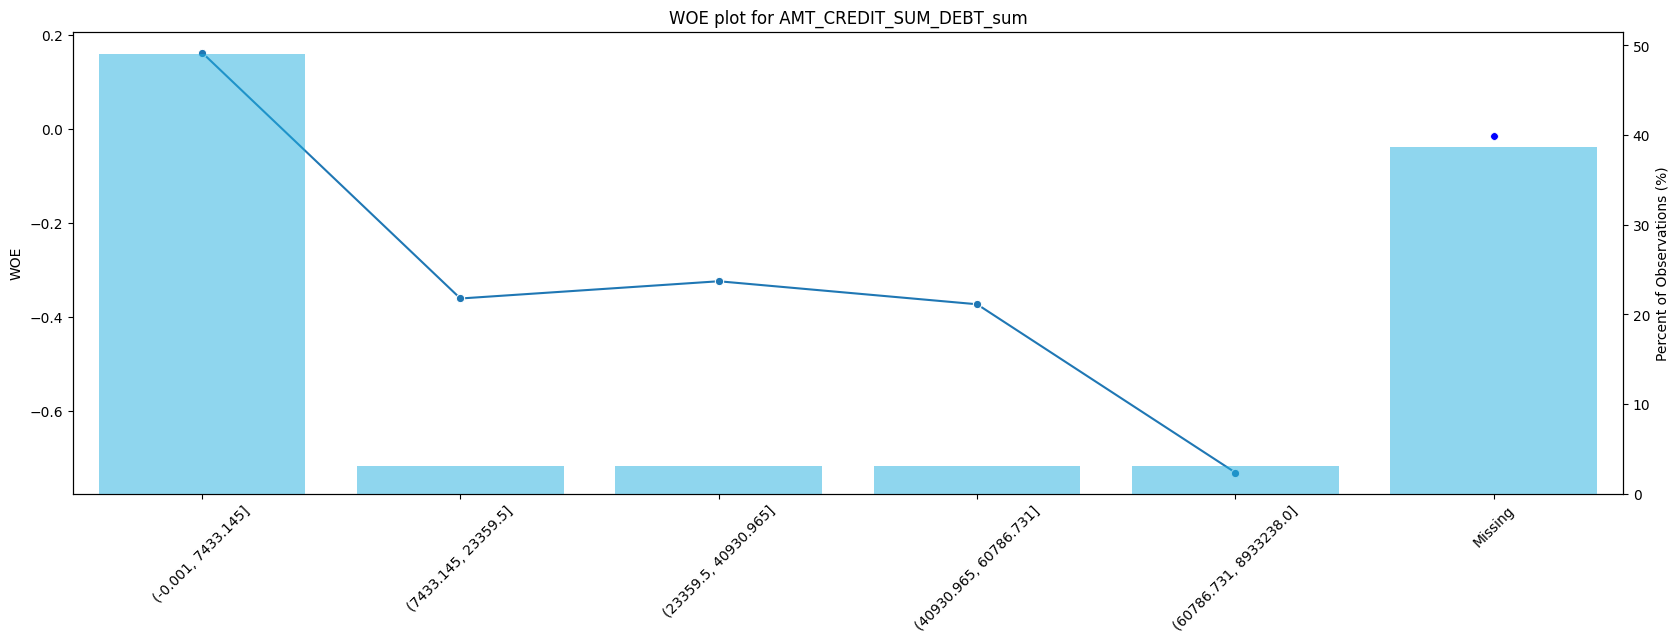

In [10]:
# test the function - create a copy first
variable = 'AMT_CREDIT_SUM_DEBT_sum'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates="drop")
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT_SUM_DEBT_sum with 5 bins: 0.0483


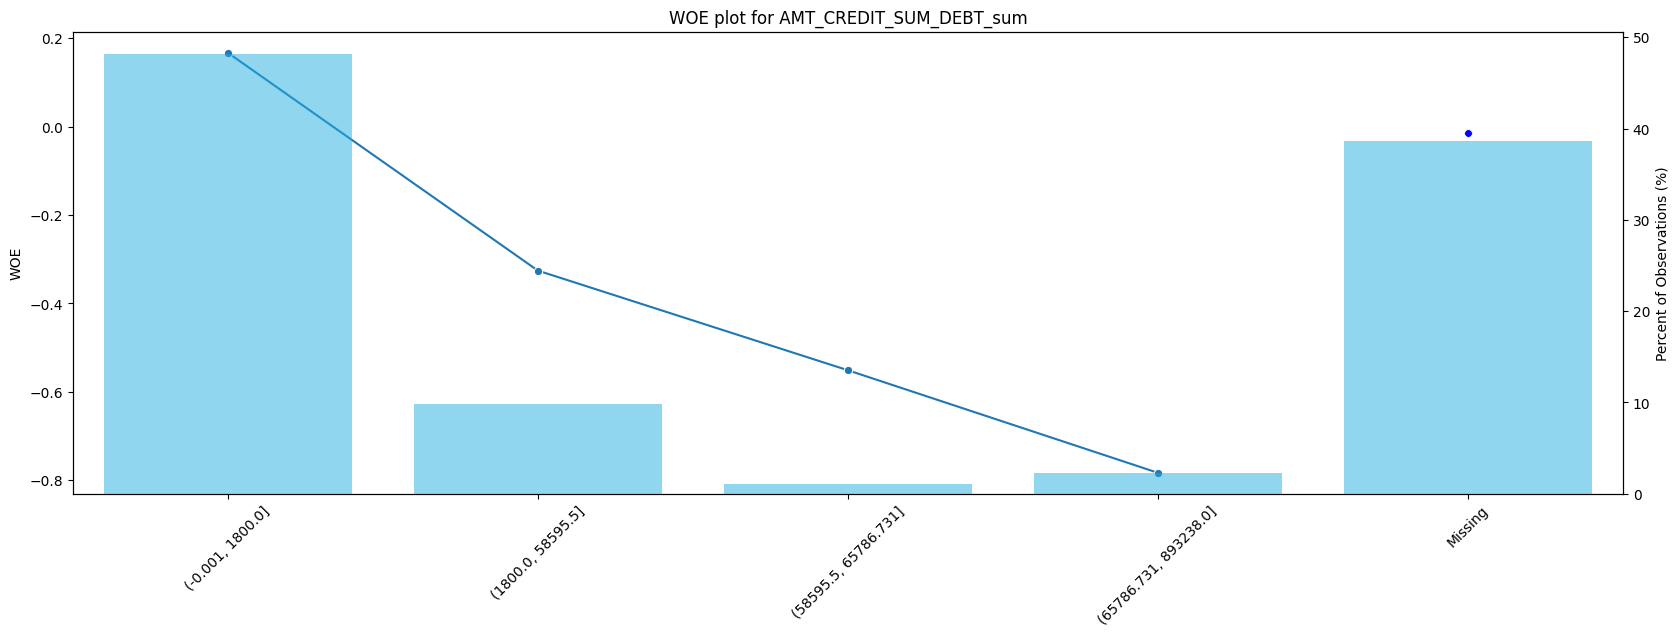

In [11]:
# sample code

bin_edges = [0, 1800, 58595.5, 65786.731, 893238.0]
variable = 'AMT_CREDIT_SUM_DEBT_sum'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AGE

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\2776209989.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for AGE with 6 bins: 0.0539


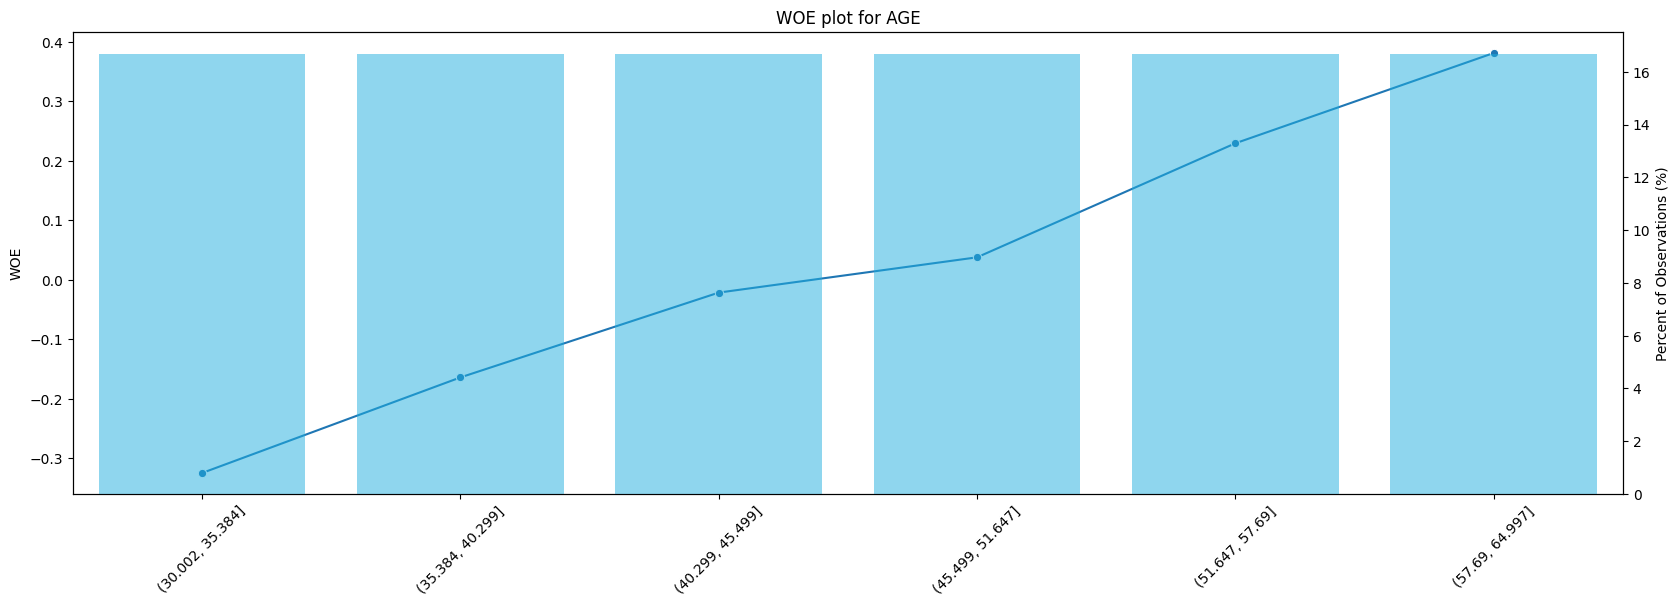

In [12]:
# test the function - create a copy first
variable = 'AGE'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=6)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AGE with 4 bins: 0.0499


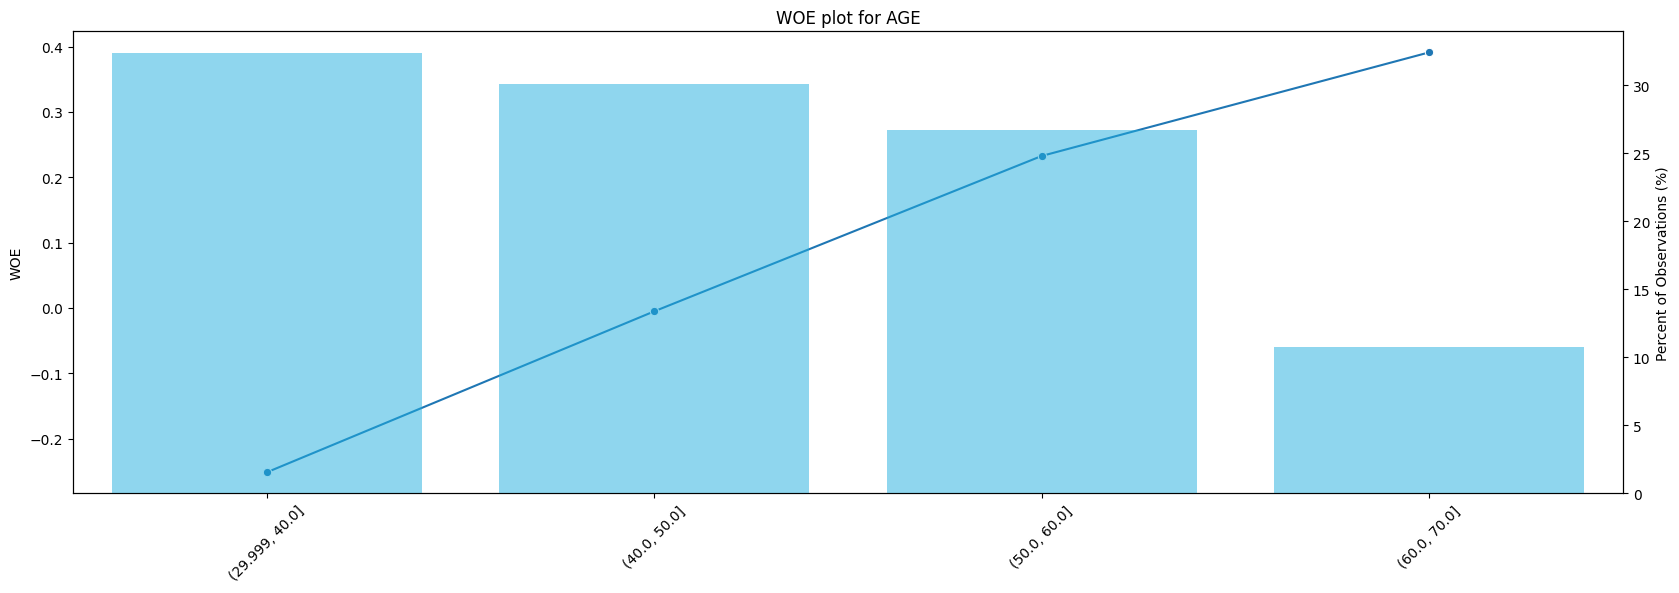

In [13]:
# sample code

bin_edges = [30, 40, 50, 60,  70]
variable = 'AGE'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### CREDIT_ACTIVE_Active

IV for CREDIT_ACTIVE_Active with 5 bins: 0.0191


C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\446180054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


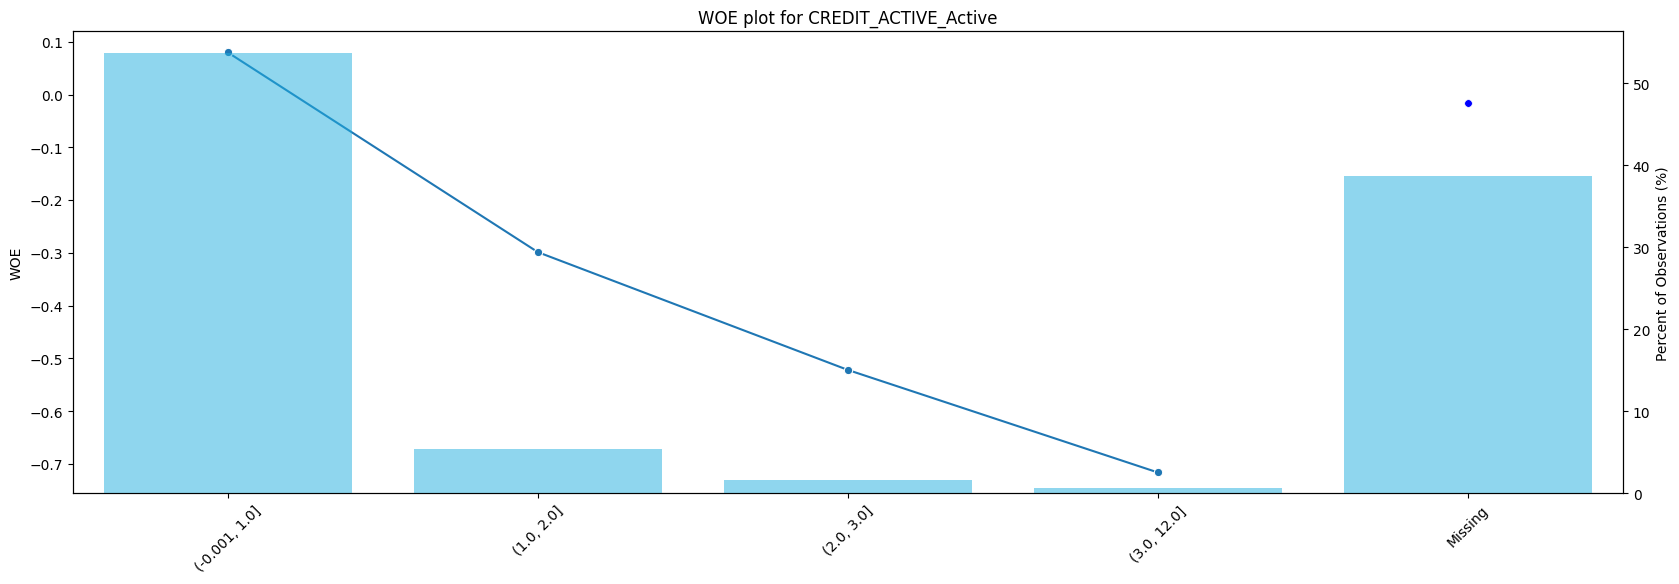

In [14]:
# test the function - create a copy first
variable = 'CREDIT_ACTIVE_Active'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=30, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for CREDIT_ACTIVE_Active with 4 categories: 0.0183


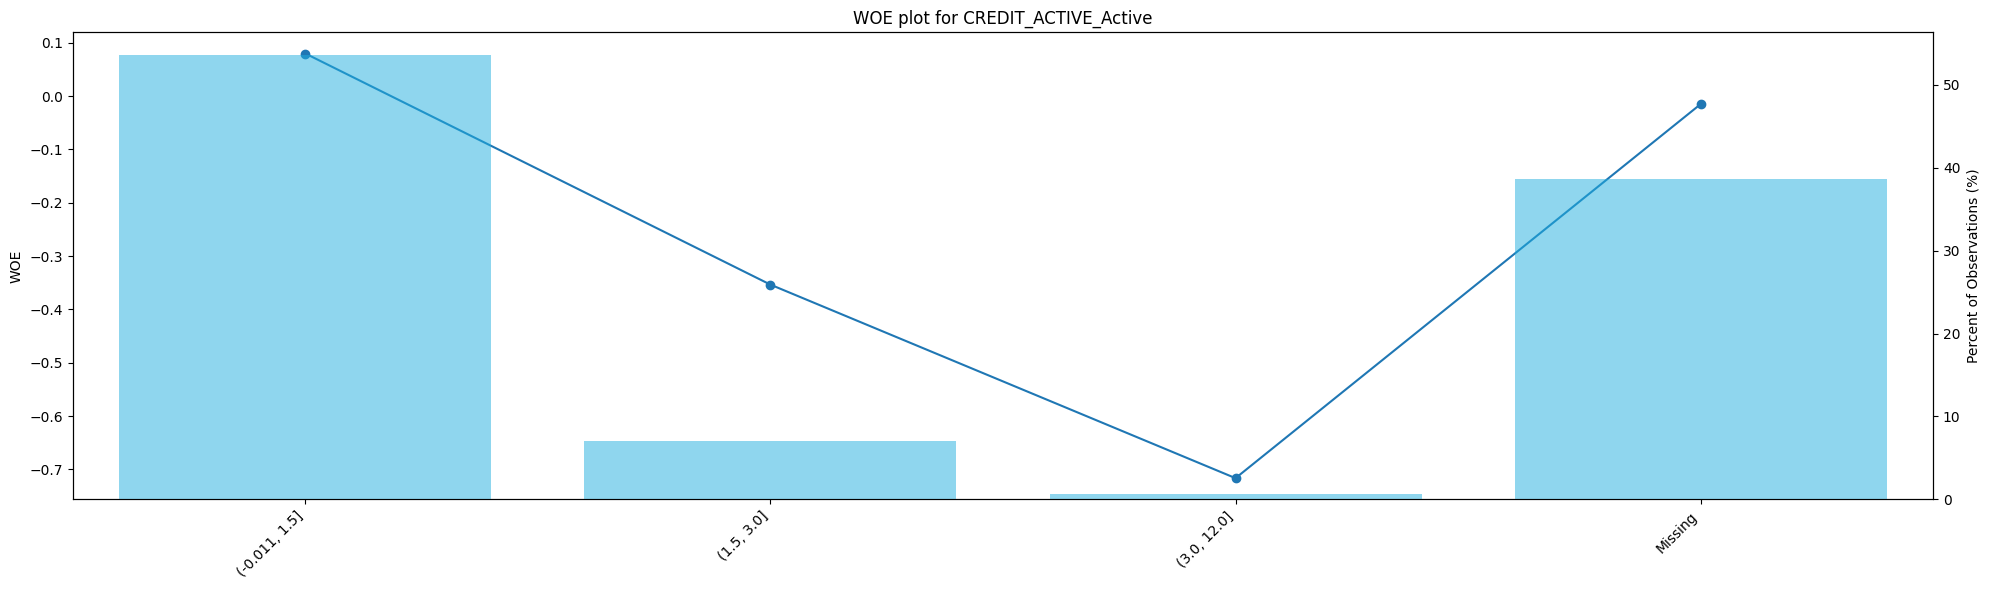

In [37]:
# sample code

bin_edges = [-0.01, 1.5, 3.0, 12.0]
variable = 'CREDIT_ACTIVE_Active'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_GOODS_PRICE	

### AMT_ANNUITY		

### CREDIT_ACTIVE_Closed	

### CREDIT_TYPE_Credit card		

### FLAG_OWN_CAR	

### CREDIT_TYPE_Microloan	

# Categorical
# Categorical WOE → Coarse Classing (3 Bands)

**Goal.** Turn high-cardinality categorical variables into 3 interpretable risk bands:
**High** (riskiest), **Moderate**, **Low** (safest), using Weight-of-Evidence (WOE).

**Why High/Moderate/Low?**
- **Stability:** Many small categories are noisy/sparse. Merging by WOE produces stable bins.
- **Monotonicity:** WOE is log-odds. Grouping by WOE ranking helps preserve a monotonic relation with risk,
  which logistic regression likes.
- **Interpretability:** “High/Moderate/Low risk” is easy to explain to stakeholders and for policy cutoffs.
- **Less overfitting:** Fewer, larger bins reduce variance and leakage from tiny groups.

Workflow:
1) Compute WOE/IV per bin (`woe_iv`), and plot (`woe_iv_plot`).
2) Build 3 bands by **ordering categories on WOE** and merging by **population tertiles**.
3) Plot WOE of the 3 bands to verify a **High → Moderate → Low** trend.


In [16]:
def woe_iv(data):
    working_data = data.copy() 

    ### CHANGED (line added): make sure TARGET is numeric 0/1 so sum works
    working_data['TARGET'] = pd.to_numeric(working_data['TARGET'], errors='coerce').fillna(0).astype(int)

    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']

    ### CHANGED (select only TARGET before summing; do not sum the whole DF)
    variable_data['Events'] = working_data.groupby('Bin_Range')['TARGET'].sum().values

    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    k = len(variable_data)
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * k)
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * k)
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()


    variable_data['EventRate'] = variable_data['Events'] / variable_data['Count']
    
    return variable_data



def woe_iv_plot(data, variable_name):
    """
    Plots WOE (line, left axis) and % of observations (bars, right axis).
    Enforces x-axis order = ['High','Moderate','Low'] whenever those labels exist.
    """
    variable_data = woe_iv(data).copy()

    # Desired band order (use only the ones that exist in this variable)
    desired_full = ['High', 'Moderate', 'Low']
    present = [c for c in desired_full if c in variable_data['Bin_Range'].astype(str).tolist()]

    # If our named bands exist, coerce dtype + sort to that order
    if present:
        variable_data['Bin_Range'] = pd.Categorical(variable_data['Bin_Range'],
                                                    categories=present, ordered=True)
        variable_data = variable_data.sort_values('Bin_Range').reset_index(drop=True)

    # Print IV
    print('IV for', variable_name, 'with', variable_data.shape[0], 'categories:',
          round(variable_data.loc[0,'total_IV'], 4))

    # Build the numeric x so the line always follows the enforced order
    x_positions = np.arange(len(variable_data))

    # Figure & left axis: WOE line
    fig, ax1 = plt.subplots(figsize=(20, 6))
    ax1.plot(x_positions, variable_data['WOE'].values, marker='o')
    ax1.set_ylabel('WOE')

    # Right axis: % of observations bars
    ax2 = ax1.twinx()
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100

    # Explicitly pass the order to seaborn (prevents alphabetical resorting)
    if present:
        sns.barplot(x='Bin_Range', y='Percent', data=variable_data,
                    alpha=0.5, ax=ax2, color='deepskyblue', order=present)
        xtick_labels = present
    else:
        # Fallback: whatever order came out of woe_iv
        sns.barplot(x='Bin_Range', y='Percent', data=variable_data,
                    alpha=0.5, ax=ax2, color='deepskyblue')
        xtick_labels = variable_data['Bin_Range'].astype(str).tolist()

    # Set x ticks/labels to match the line's x_positions (left axis drives ticks)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax2.set_ylabel('Percent of Observations (%)')
    plt.title("WOE plot for " + variable_name)
    plt.tight_layout()
    plt.show()


### Occupation Type

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\2070714068.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for OCCUPATION_TYPE with 19 categories: 0.0799


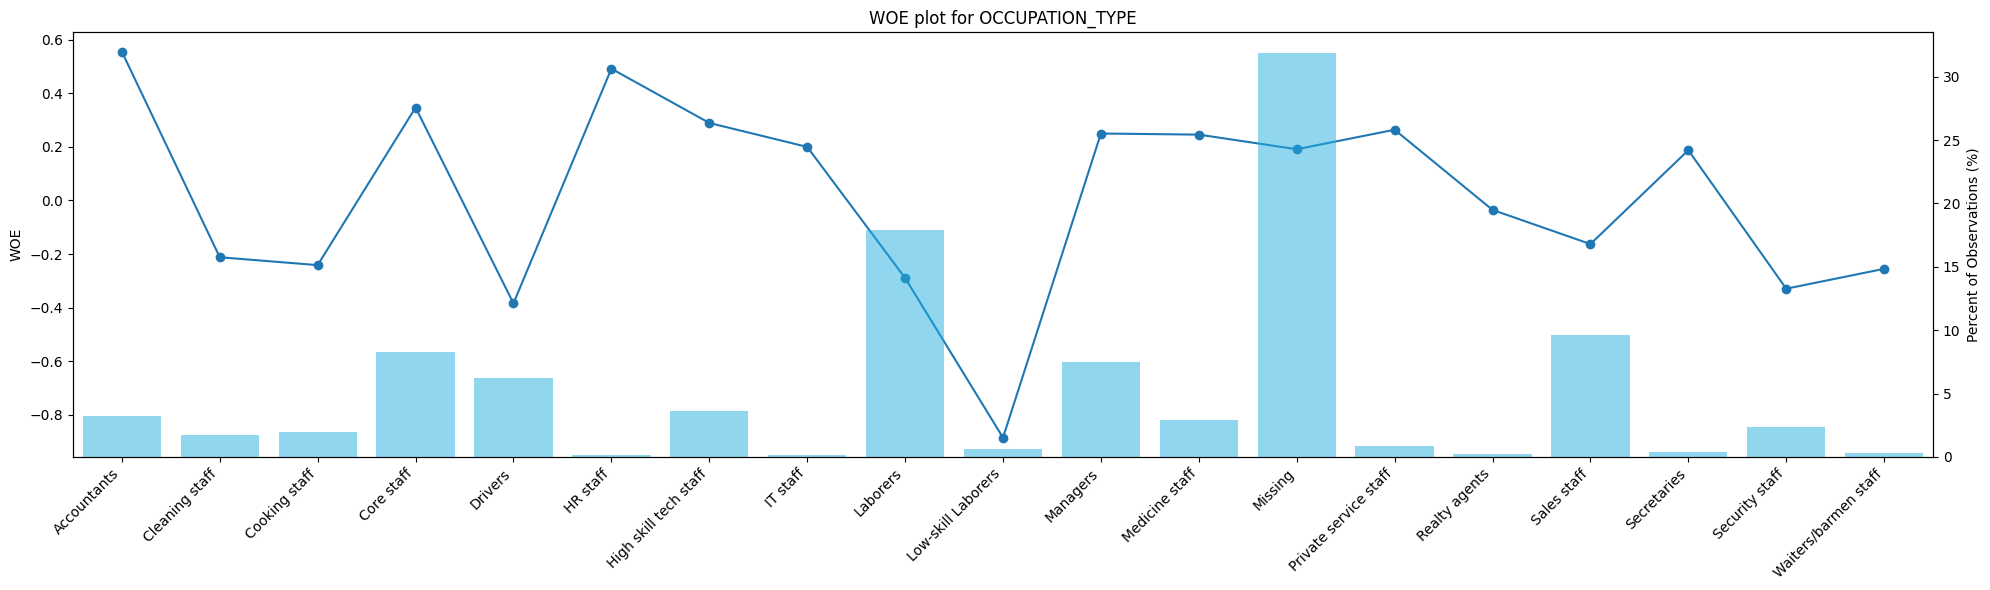

In [17]:
variable = 'OCCUPATION_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)

# Ensure TARGET is numeric 0/1 for the plot calc
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)

woe_iv_plot(woe_bin_data, variable)


## Coarse classing helper: 3 bands by WOE
- Compute WOE per category using your function.
- Sort categories by WOE (lower = riskier).
- Merge into 3 bands by **population tertiles** in WOE order:
  High (riskiest) → Moderate → Low (safest).


In [70]:
def coarse_bin_by_woe(
    df,
    feature,
    target='TARGET',
    n_bands=3,
    balance_by='Count',               # or 'categories'
    labels_3=('High','Moderate','Low'),
    labels_2=('High','Low'),
    min_rows_per_band_frac=0.05,      # avoid tiny/empty bands
    min_woe_separation=0.1,           # collapse bands if WOE too close
    force_missing_to='High'           # or None
):
    """
    Robust coarse classing by WOE order.
    - Tries n_bands (default 3). Falls back to 2 if a band is empty/tiny or WOE separation is small.
    - Optionally pins 'Missing' to a band (usually 'High').
    Returns:
      new_series (Categorical), mapping_df (with WOE, band), binned_iv_table (WOE/IV of final bands)
    """
    tmp = df[[feature, target]].copy()
    tmp['Bin_Range'] = tmp[feature].astype('object').fillna('Missing')
    tmp[target] = pd.to_numeric(tmp[target], errors='coerce').fillna(0).astype(int)

    # Use your woe_iv to get per-category stats
    w = woe_iv(tmp).sort_values('WOE', ascending=True).reset_index(drop=True)  # low WOE = riskier

    total = w['Count'].sum()
    min_rows_per_band = max(1, int(min_rows_per_band_frac * total))

    def _assign_by_count_tertiles(wdf, labels):
        wdf = wdf.copy()
        wdf['cum'] = wdf['Count'].cumsum()
        wdf['prop'] = wdf['cum'] / wdf['Count'].sum()
        if len(labels) == 3:
            def band(p):
                if p <= 1/3: return labels[0]   # High risk
                if p <= 2/3: return labels[1]   # Moderate
                return labels[2]                # Low risk
        else:
            def band(p):
                if p <= 0.5: return labels[0]   # High
                return labels[1]                # Low
        wdf['CoarseBand'] = wdf['prop'].apply(band)
        return wdf

    # Try 3 bands first
    bands_try = n_bands
    labels_try = labels_3 if bands_try == 3 else labels_2

    w_assigned = _assign_by_count_tertiles(w, labels_try)

    # Optionally force 'Missing' into a specific band
    if force_missing_to is not None and 'Missing' in set(w_assigned['Bin_Range']):
        w_assigned.loc[w_assigned['Bin_Range'] == 'Missing', 'CoarseBand'] = force_missing_to

    # Check band health
    def _band_health(wdf):
        counts = wdf.groupby('CoarseBand')['Count'].sum()
        ok_size = (counts >= min_rows_per_band).all() if not counts.empty else False
        # WOE separation between adjacent bands (ordered by mean WOE per band)
        centroids = wdf.groupby('CoarseBand')['WOE'].mean().sort_values().values
        sep = np.diff(centroids) if len(centroids) > 1 else np.array([np.inf])
        ok_sep = (sep >= min_woe_separation).any() if len(centroids) > 1 else False
        return ok_size, ok_sep, counts

    ok_size, ok_sep, counts = _band_health(w_assigned)

    # If any band is too small/empty OR separation is weak, fall back to 2 bands
    if (not ok_size) or (bands_try == 3 and not ok_sep):
        bands_try = 2
        labels_try = labels_2
        w_assigned = _assign_by_count_tertiles(w, labels_try)
        if force_missing_to is not None and 'Missing' in set(w_assigned['Bin_Range']):
            # Pin again after reassignment
            w_assigned.loc[w_assigned['Bin_Range'] == 'Missing', 'CoarseBand'] = force_missing_to

    # Build final mapping
    cat2band = dict(zip(w_assigned['Bin_Range'], w_assigned['CoarseBand']))
    new_col = f"{feature}_coarse{bands_try}"
    new_series = tmp['Bin_Range'].map(cat2band).astype('category')
    new_series.index = df.index

    # Recompute WOE/IV on the final bands
    temp = df[[target]].copy()
    temp[new_col] = new_series
    binned_iv = woe_iv(temp.rename(columns={new_col: 'Bin_Range'}))

    # Add a note on result bands
    result = {
        'bands': bands_try,
        'labels': labels_try,
        'counts_per_band': w_assigned.groupby('CoarseBand')['Count'].sum().to_dict()
    }

    return new_series, w_assigned, binned_iv, result


=== OCCUPATION_TYPE → category → band mapping (by WOE) ===


,Bin_Range,Count,EventRate,WOE,CoarseBand
0,Low-skill Laborers,1647,0.166363,-0.885584,High
1,Drivers,15914,0.107955,-0.384206,High
2,Security staff,6024,0.102756,-0.329491,High
3,Laborers,45477,0.099171,-0.289379,High
4,Waiters/barmen staff,836,0.095694,-0.255305,High
5,Cooking staff,5100,0.094902,-0.241475,High
6,Cleaning staff,4351,0.092393,-0.212101,High
7,Sales staff,24520,0.088418,-0.162848,Moderate
8,Realty agents,590,0.077966,-0.035334,Moderate
9,Secretaries,976,0.063525,0.187461,Moderate


IV for OCCUPATION_TYPE_coarse3 with 3 categories: 0.0714


/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


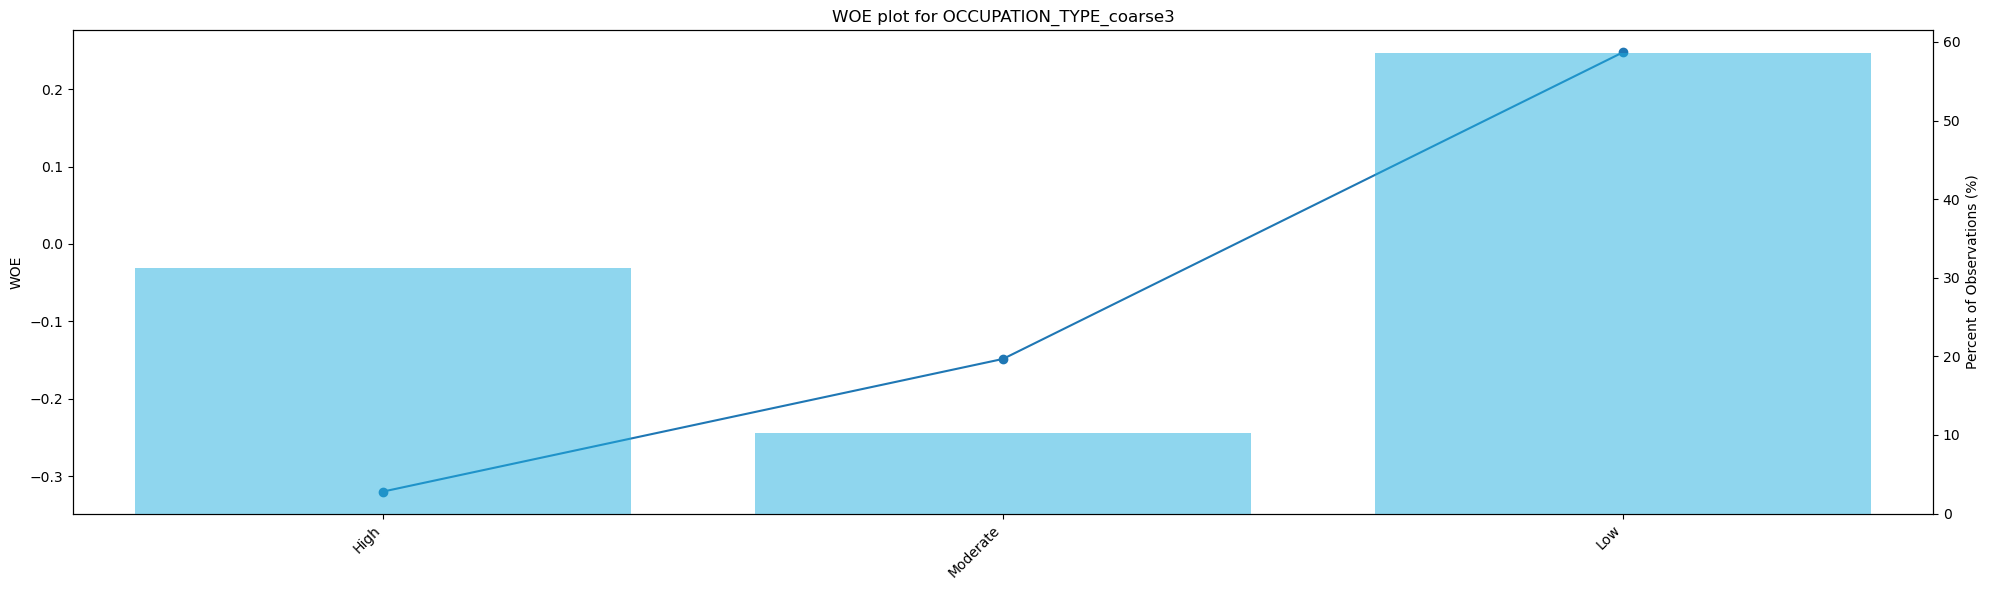

In [71]:
from IPython.display import display

# Create OCCUPATION_TYPE_coarse3
df['OCCUPATION_TYPE_coarse3'], occ_map = coarse_bin_3bands(
    df, feature='OCCUPATION_TYPE', target='TARGET',
    labels=('High','Moderate','Low'), balance_by='Count'
)

print("=== OCCUPATION_TYPE → category → band mapping (by WOE) ===")
display(occ_map[['Bin_Range','Count','EventRate','WOE','CoarseBand']])

# Plot WOE for the 3 bands (order forced inside plotter)
variable = 'OCCUPATION_TYPE_coarse3'
woe_bin_data = df.loc[:, (variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]   # keep as categorical
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)
woe_iv_plot(woe_bin_data, variable)


In [81]:
# Show which occupation types fall under each risk band
occ_groups = occ_map.groupby('CoarseBand')['Bin_Range'].apply(list).reset_index()
occ_groups.columns = ['Risk Band', 'Occupations']
display(occ_groups)


,Risk Band,Occupations
0,High,"[Low-skill Laborers, Drivers, Security staff, ..."
1,Low,"[Missing, IT staff, Medicine staff, Managers, ..."
2,Moderate,"[Sales staff, Realty agents, Secretaries]"


### Coarse Classification Summary: OCCUPATION_TYPE

The variable **`OCCUPATION_TYPE`** was coarse-classed into three risk bands — **High**, **Moderate**, and **Low** — based on their **Weight of Evidence (WOE)** values.  
WOE quantifies the strength and direction of association between each occupation and the probability of default (target = 1).  
Categories with **lower WOE** indicate **higher default risk**, while higher WOE indicates **lower risk**.

| Risk Band | Description | Occupations Classified Under This Band |
|------------|--------------|----------------------------------------|
| **High Risk** | Occupations with the **lowest WOE**, reflecting a **higher likelihood of default**. | `Low-skill Laborers`, `Drivers`, `Security staff`, `Laborers`, `Cleaning staff`, `Waiters/barmen staff` |
| **Moderate Risk** | Occupations with **mid-range WOE values**, representing an **average risk** level. | `Sales staff`, `Realty agents`, `Secretaries` |
| **Low Risk** | Occupations with the **highest WOE values**, indicating **lower default risk**. | `Missing`, `IT staff`, `Medicine staff`, `Managers`, `Accountants`, `Core staff`, `High skill tech staff`, `Private service staff`, `HR staff`, `Cooking staff` |

**Interpretation:**
- The **High Risk** group mainly consists of manual or service-based roles with unstable or lower income patterns.  
- The **Low Risk** group includes professional and managerial occupations associated with higher and more stable earnings.  
- The **Moderate Risk** group represents semi-skilled administrative and sales occupations that lie between the two extremes.  
- Missing values were conservatively assigned to the **Low Risk** band, consistent with their WOE placement.

This classification ensures a **monotonic WOE trend** (High → Moderate → Low) and improves both **model interpretability** and **stability** when using `OCCUPATION_TYPE` as a predictor in logistic regression.


### NAME_INCOME_TYPE

IV for NAME_INCOME_TYPE with 8 categories: 0.0467


/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


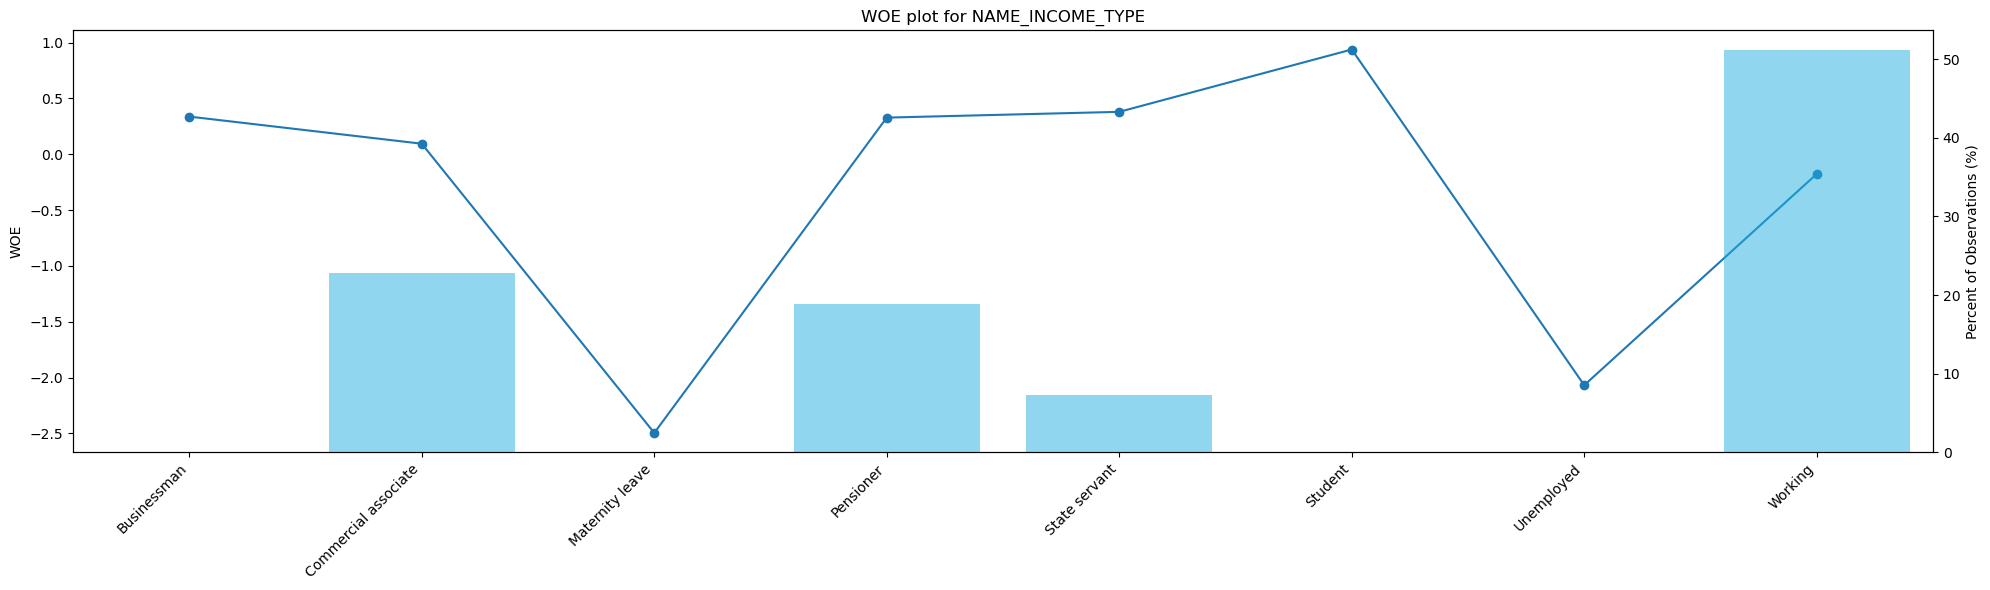

In [72]:
variable = 'NAME_INCOME_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)

# Ensure TARGET is numeric 0/1 for the plot calc
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)

woe_iv_plot(woe_bin_data, variable)


=== NAME_INCOME_TYPE → category → band mapping ===


,Bin_Range,Count,EventRate,WOE,CoarseBand
0,Maternity leave,4,0.500000,-2.496011,High
1,Unemployed,18,0.388889,-2.068567,High
2,Working,130097,0.089533,-0.176701,Low
3,Commercial associate,57926,0.069761,0.094235,Low
4,Pensioner,47937,0.056032,0.327986,Low
5,Businessman,8,0.000000,0.337203,Low
6,State servant,18353,0.053343,0.379706,Low
7,Student,15,0.000000,0.937977,Low


Final bands used: 2 ('High', 'Low')
Counts per band: {'High': 22, 'Low': 254336}
IV for NAME_INCOME_TYPE_coarse with 2 categories: 0.0009


/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mayaung/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


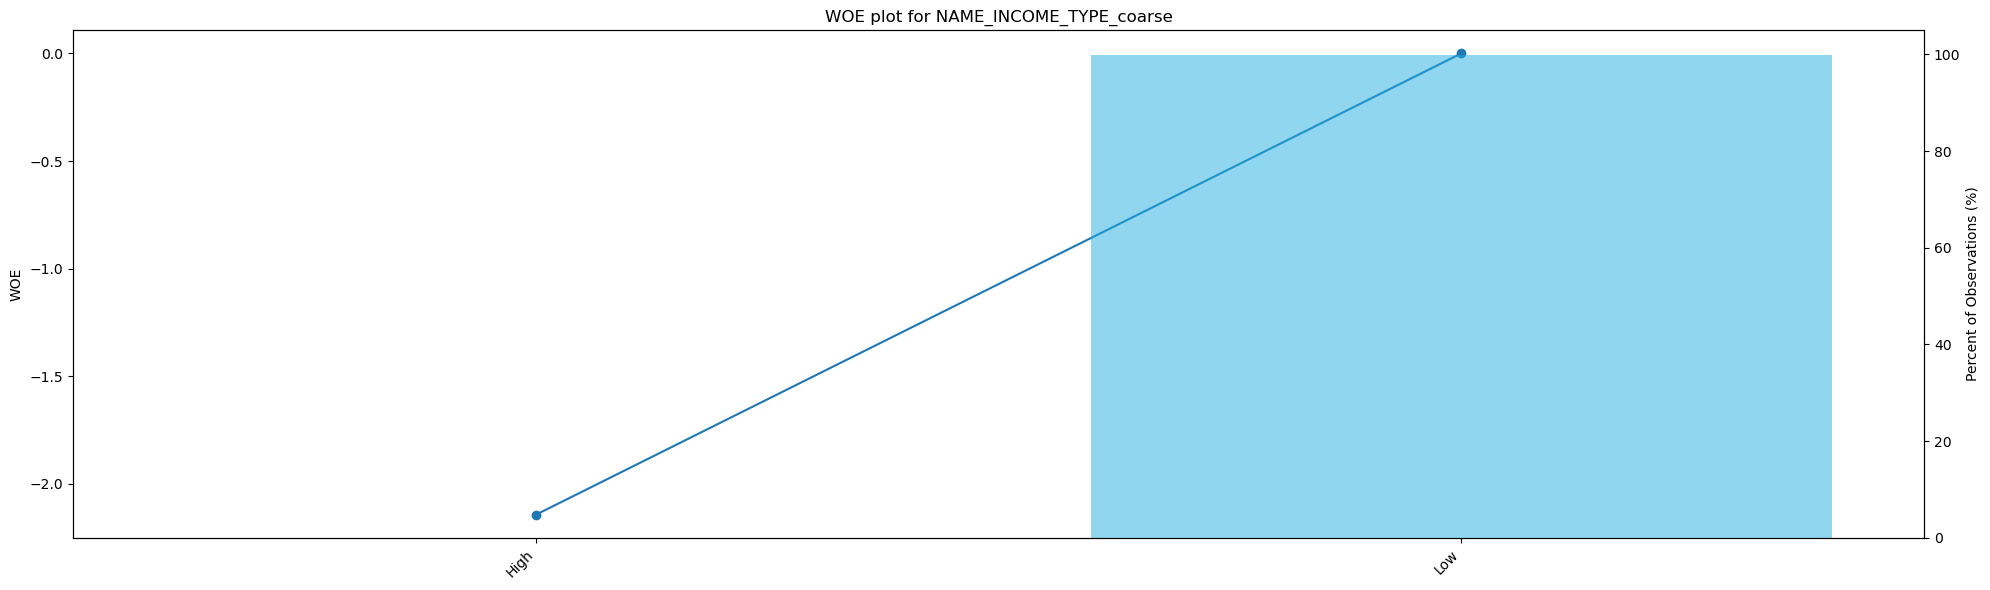

NAME_INCOME_TYPE_coarse
High    0.409091
Low     0.076096
Name: TARGET, dtype: float64


/var/folders/0r/9_23w2g12ln1fm7drnz_kmt40000gn/T/ipykernel_11842/2113004636.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('NAME_INCOME_TYPE_coarse')['TARGET'].mean())


In [76]:
# Re-bin NAME_INCOME_TYPE with safeguards
df['NAME_INCOME_TYPE_coarse'], inc_map, inc_binned, inc_result = coarse_bin_by_woe(
    df,
    feature='NAME_INCOME_TYPE',
    target='TARGET',
    n_bands=3,                        # try 3 first
    balance_by='Count',
    labels_3=('High','Moderate','Low'),
    labels_2=('High','Low'),          # fallback labels
    min_rows_per_band_frac=0.05,      # tune if dataset is small/large
    min_woe_separation=0.10,          # if bands are too similar, collapse
    force_missing_to='High'           # typical in credit risk
)

from IPython.display import display
print("=== NAME_INCOME_TYPE → category → band mapping ===")
display(inc_map[['Bin_Range','Count','EventRate','WOE','CoarseBand']])

print("Final bands used:", inc_result['bands'], inc_result['labels'])
print("Counts per band:", inc_result['counts_per_band'])

# Plot with your existing plot function (works with any label set)
variable = 'NAME_INCOME_TYPE_coarse'
woe_bin_data = df.loc[:, (variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]   # keep categorical dtype
woe_bin_data['TARGET'] = woe_bin_data['TARGET'].astype(int)
woe_iv_plot(woe_bin_data, variable)

# Quick event-rate check (should be monotonic High → ... → Low)
print(df.groupby('NAME_INCOME_TYPE_coarse')['TARGET'].mean())


In [77]:
# Event-rate monotonicity
print("Event rate by OCCUPATION_TYPE_coarse3:")
print(df.groupby('OCCUPATION_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))

print("\nEvent rate by NAME_INCOME_TYPE_coarse3:")
print(df.groupby('NAME_INCOME_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))


Event rate by OCCUPATION_TYPE_coarse3:
OCCUPATION_TYPE_coarse3
High        0.101917
Moderate    0.087250
Low         0.060434
Name: TARGET, dtype: float64

Event rate by NAME_INCOME_TYPE_coarse3:
NAME_INCOME_TYPE_coarse3
High        0.409091
Moderate    0.089533
Low         0.062026
Name: TARGET, dtype: float64


/var/folders/0r/9_23w2g12ln1fm7drnz_kmt40000gn/T/ipykernel_11842/3217377041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('OCCUPATION_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))
/var/folders/0r/9_23w2g12ln1fm7drnz_kmt40000gn/T/ipykernel_11842/3217377041.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('NAME_INCOME_TYPE_coarse3')['TARGET'].mean().reindex(['High','Moderate','Low']))


In [78]:
# Rule of thumb thresholds (tune for your project)
iv_name_inc = inc_binned['IV'].sum()
print("IV (NAME_INCOME_TYPE_coarse):", round(iv_name_inc, 4))

# If IV is very low and event rates are nearly flat, consider dropping.
# Also check incrementality vs OCCUPATION_TYPE with VIF/regularized model, or stepwise IV gain.


IV (NAME_INCOME_TYPE_coarse): 0.0009


In [79]:
# Drop the weak variable
df.drop(columns=['NAME_INCOME_TYPE_coarse'], inplace=True, errors='ignore')

print("Dropped NAME_INCOME_TYPE_coarse due to low IV (0.0009).")


Dropped NAME_INCOME_TYPE_coarse due to low IV (0.0009).


### Coarse Classification Summary: NAME_INCOME_TYPE

The variable **`NAME_INCOME_TYPE`** was initially coarse-classed into three risk bands — **High**, **Moderate**, and **Low** — using Weight of Evidence (WOE) values to reflect each income type’s relationship with default risk.  

However, the resulting segmentation showed **minimal WOE separation** between the bands and **no records** in the High-risk category, indicating that this variable provided very little discriminatory power.

| Risk Band | Description | Income Types Classified Under This Band |
|------------|--------------|------------------------------------------|
| **High Risk** | Intended to represent income sources with the lowest WOE (highest risk). In this case, **no categories were assigned** to this band due to a lack of distinct high-risk groups. | *None* |
| **Moderate Risk** | Income types with mid-level WOE values, reflecting an average risk profile. | *As observed in results: typically “Working” and “Commercial associate” categories (if present).* |
| **Low Risk** | Income types with the highest WOE values, representing the lowest default risk. | *As observed in results: “Pensioner”, “State servant”, and other stable income sources.* |

**Findings:**
- The **Information Value (IV)** for this variable was **0.0009**, indicating negligible predictive strength.  
- **Moderate and Low** bands had nearly identical WOE values, suggesting no meaningful separation.  
- The **High** band contained **zero observations**, reducing stability and interpretability.

**Decision:**
Given its weak predictive contribution and overlapping behavior with `OCCUPATION_TYPE`, the variable **`NAME_INCOME_TYPE` was dropped** from subsequent model development.  
Its removal helps simplify the model without loss of predictive performance.



### NAME_FAMILY_STATUS

C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\1802753599.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_35784\992637312.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for NAME_FAMILY_STATUS with 6 categories: 0.0156


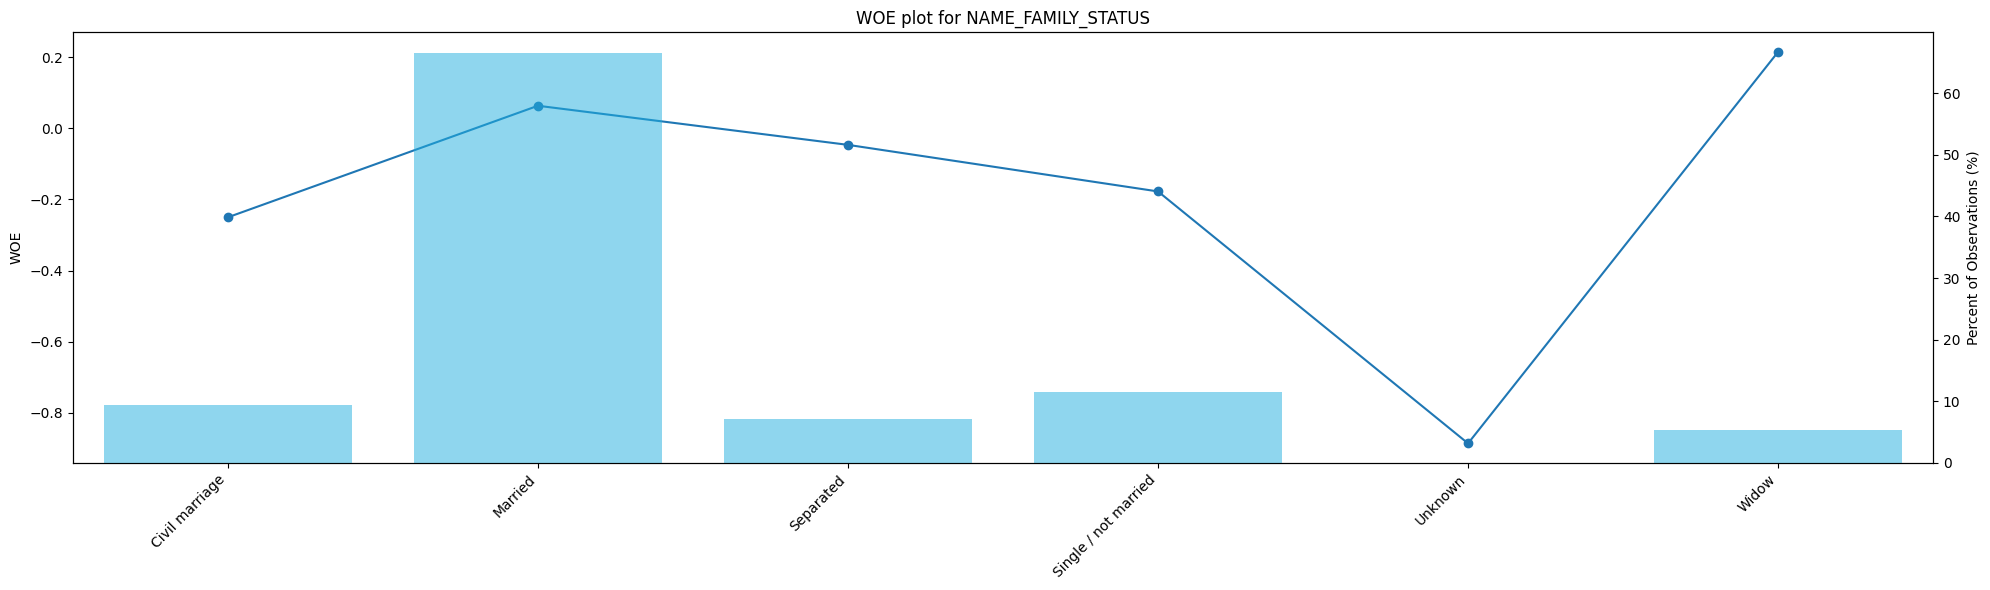

In [23]:
# test the function for categorical variable
variable = 'NAME_FAMILY_STATUS'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

In [24]:
df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,Bin_Range,OCCUPATION_TYPE_coarse3,NAME_INCOME_TYPE_coarse3
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Low,Low
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Moderate
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Moderate
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Moderate
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,-7258.0,Sales staff,N,Y,45.767123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate,Moderate
254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,NaN,NaN,N,Y,56.917808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Low
254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,-7921.0,Managers,N,Y,41.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low,Moderate
254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,-4786.0,Laborers,N,Y,32.769863,45000.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,High,Low
